In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
def load_img(path_to_img):
    #load and preprocess image to be suitable for the model
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] 
    return img

In [ ]:
def tensor_to_image(tensor):
   #turn a tensor as a PIL image
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
# --- 2. load VGG19 model ---

# content layer we usually choose deeper layers, style layers choose multiple layers of different depths
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

def vgg_layers(layer_names):
    #create a VGG19 model that returns a list of intermediate output values
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
# --- 3. define a model to extract style and content ---
def gram_matrix(input_tensor):
    """计算格拉姆矩阵，用于捕捉风格"""
    result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

In [ ]:
# define the weighted loss function
style_weight = 1e-1
content_weight = 1e4

def style_content_loss(outputs, content_targets, style_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    
    # style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    
    # weight the losses
    content_loss *= content_weight / 100 
    style_loss *= style_weight / 100
    
    total_loss = content_loss + style_loss
    return total_loss

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    # create a model that returns the style and content tensors
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "inputs: a tuple of (style_image, content_image)"
        inputs = inputs * 255.0 # VGG19 expects input in range [0, 255]
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}



Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Total time: 55.7s


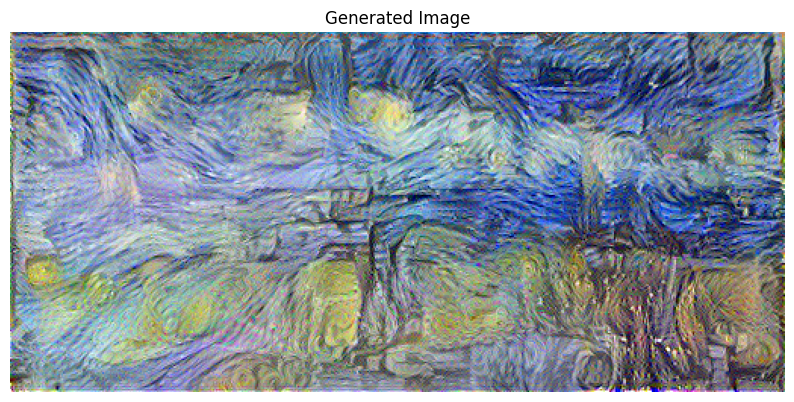

In [ ]:
# --- 4. train the model ---

content_path = '05-example-image.jpg' 
style_path = '05-Van_Gogh_Starry_Night.jpg'   

content_image = load_img(content_path)
style_image = load_img(style_path)

extractor = StyleContentModel(style_layers, content_layers)

# calculate the target content and style features (only once)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# initialize the image to be optimized
image = tf.Variable(content_image)

# define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)



# use @tf.function to compile into a graph for faster training
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, content_targets, style_targets)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))


# --- start training ---
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
    print(f"Epoch {n+1}/{epochs}")

end = time.time()
print("Total time: {:.1f}s".format(end - start))

# --- 5. display the result ---
final_image = tensor_to_image(image)
final_image.save('05-Generated_image.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.title('Generated Image')
plt.axis('off')
plt.show()